# Source Magnitude-Frequency Distribution

This notebook currently supports study of whole catalogs as well as individual source catalogs. It should perhaps be broken into two, doing just one thing or the other, but currently to study a source catalog you need to first load the whole catalog and then decluster it, each time.

In [1]:
%matplotlib inline
import os
import json
import codecs
import pickle
import numpy as np
import toolbox as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 2

import hmtk.seismicity.max_magnitude as m_max
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.seismicity.declusterer as decluster
import hmtk.plotting.seismicity.catalogue_plots as cp
import hmtk.plotting.seismicity as sp

from copy import deepcopy
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
import hmtk.seismicity.occurrence as occurrence

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector

In [2]:
# Marmaris, Turkey
target_lon = 28.25
target_lat = 36.85

sources_file = "../geology/MarmarisDangerousSources15_300km.xml"

catalogue_filename = '../seismicity/Marmaris-catalogue1_homogenised_cleaned.csv'

In [3]:
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  1.98
Maximum magnitude:  7.5
Number of events:  30546
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


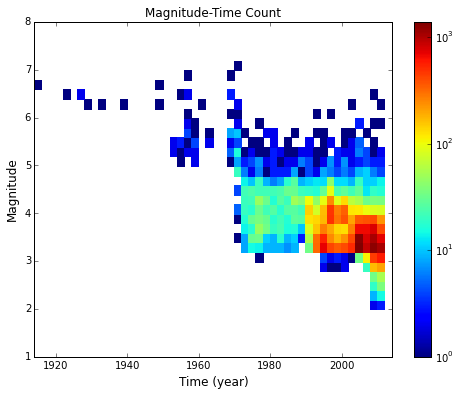

In [4]:
cp.plot_magnitude_time_density(catalogue, 0.2, 2)

In [5]:
# my best bet, eyeballing the magnitude-time density plot
completeness_table_eyeball = np.array([
        [2004, 3.5],
        [1994, 4.0], 
        [1974, 4.5],
        [1912, 6.5],
    ]) 

Completeness table using Stepp method (1971)


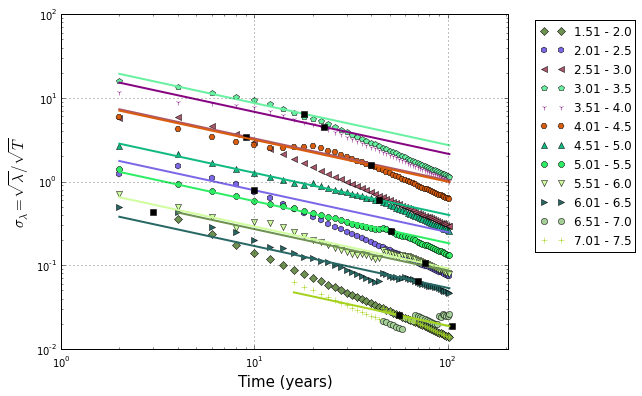

[[ 2012.      1.5]
 [ 2005.      2. ]
 [ 2006.      2.5]
 [ 1997.      3. ]
 [ 1992.      3.5]
 [ 1975.      4. ]
 [ 1971.      4.5]
 [ 1964.      5. ]
 [ 1939.      5.5]
 [ 1945.      6. ]
 [ 1910.      6.5]
 [ 1959.      7. ]]
ERROR: Completeness table shows increase in completeness magnitude between 2005 and 2006


In [6]:
m_bin = 0.5
stepp_config = {'magnitude_bin': m_bin, 'time_bin': 2, 
               'increment_lock': False}
completeness_algorithm = Stepp1971()
completeness_table_stepp = completeness_algorithm.completeness(
    catalogue, stepp_config)
print 'Completeness table using Stepp method (1971)'

plot_stepp_1972.create_stepp_plot(completeness_algorithm)
plt.show()

np.set_printoptions(suppress=True)
print completeness_table_stepp

degradation = (completeness_table_stepp[:-1,0] 
         < completeness_table_stepp[1:,0])
if np.any(degradation):
    print "ERROR: Completeness table shows increase in completeness magnitude between %d and %d" % (
        completeness_table_stepp[np.where(degradation)[0][0],0],
        completeness_table_stepp[np.where(degradation)[0][0] + 1,0])

In [7]:
# Stepp result has inversions, so it doesn't work raw, 
# but it still fails if you edit it to make something reasonable
completeness_table_stepp_modified = np.array([
        [2006, 2.5],
        [1997, 3.0],
        [1992, 3.5],
        [1975, 4.0],
        [1971, 4.5],
        [1964, 5.0],
    ])

completeness_table_catalog = completeness_table_eyeball

In [8]:
print "Whole-catalog Gutenberg-Richter fitting"

# Weichert Method
recurrence1 = occurrence.weichert.Weichert()
weichert_config = {'magnitude_interval': m_bin, 'bvalue': 1.0, 
                   'itstab': 1e-5, 'maxiter': 1000}
b_cat_1, sigma_b_cat_1, a_cat_1, sigma_a_cat_1 = recurrence1.calculate(
    catalogue, weichert_config, completeness=completeness_table_catalog)

print "--- Weichert ---"
print "b = %.4f +/- %.4f, a = %.4f +/- %.4f" % (
    b_cat_1, sigma_b_cat_1, a_cat_1, sigma_a_cat_1)

# Weighted Maximum Likelihood Method
recurrence2 = occurrence.b_maximum_likelihood.BMaxLikelihood()
wml_config = {'magnitude_interval': m_bin, 'Average Type': 'Weighted'}
b_cat_2, sigma_b_cat_2, a_cat_2, sigma_a_cat_2 = recurrence2.calculate(
    catalogue, wml_config, completeness=completeness_table_catalog)

print "--- Weighted Maximum Likelihood ---"
print "b = %.4f +/- %.4f, a = %.4f +/- %.4f" % (
    b_cat_2, sigma_b_cat_2, a_cat_2, sigma_a_cat_2)

Whole-catalog Gutenberg-Richter fitting
--- Weichert ---
b = 1.2720 +/- 0.0069, a = 7.2404 +/- 0.0030
--- ctime 2004.0  m_c 3.5
--- ctime 1994.0  m_c 4.0
--- ctime 1974.0  m_c 4.5
--- ctime 1912.0  m_c 6.5
--- Weighted Maximum Likelihood ---
b = 1.2720 +/- 0.0141, a = 7.3775 +/- 0.0504


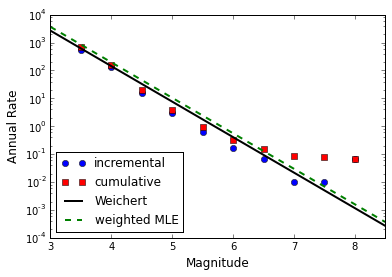

Completeness table used
[[ 2004.      3.5]
 [ 1994.      4. ]
 [ 1974.      4.5]
 [ 1912.      6.5]]


In [9]:
end_year = np.max(catalogue.data['year'])
recurrence_cat = cp.get_completeness_adjusted_table(
    catalogue, completeness_table_catalog, m_bin, end_year)
plt.semilogy(recurrence_cat[:, 0], recurrence_cat[:, 1], 'bo', label='incremental')
plt.semilogy(recurrence_cat[:, 0], recurrence_cat[:, 2], 'rs', label='cumulative')
x_lim = np.array([recurrence_cat[0, 0] - m_bin, recurrence_cat[-1, 0] + m_bin])
plt.xlim(x_lim)
plt.plot(x_lim, 10**(a_cat_1 - b_cat_1*x_lim), 'k-', label='Weichert')
plt.plot(x_lim, 10**(a_cat_2 - b_cat_2*x_lim), 'g--', label='weighted MLE')
plt.xlabel('Magnitude', fontsize='large')
plt.ylabel('Annual Rate', fontsize='large')
plt.legend(loc='lower left')
plt.show()

print 'Completeness table used'
print completeness_table_catalog

In [10]:
# identify clusters
declusterer = decluster.dec_gardner_knopoff.GardnerKnopoffType1()
decluster_config = {
    'time_distance_window': decluster.distance_time_windows.UhrhammerWindow(), 
    'fs_time_prop': 1.0}
cluster_index, cluster_flag = declusterer.decluster(catalogue, decluster_config)

# purge catalogue
declustered = deepcopy(catalogue)
mainshock_flag = cluster_flag == 0 
declustered.purge_catalogue(mainshock_flag)

In [11]:
cm_config = {'number_bootstraps': 500}
cmmax_estimator = m_max.cumulative_moment_release.CumulativeMoment()
cmmax, cmmax_uncertainty = cmmax_estimator.get_mmax(
    declustered, cm_config)
print "Maximum Magnitude (estimate): %.3f +/- %.3f" % (
    cmmax, cmmax_uncertainty)

Maximum Magnitude (estimate): nan +/- nan


In [12]:
# Map configuration
span = 1.5 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

In [13]:
# Reading the models 
parser = nrmlSourceModelParser(sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

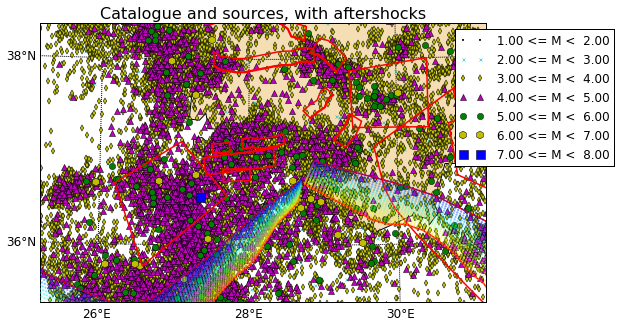

Number of events:  30546


In [14]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, with aftershocks')
my_map.add_catalogue(catalogue, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(catalogue.data['magnitude'])

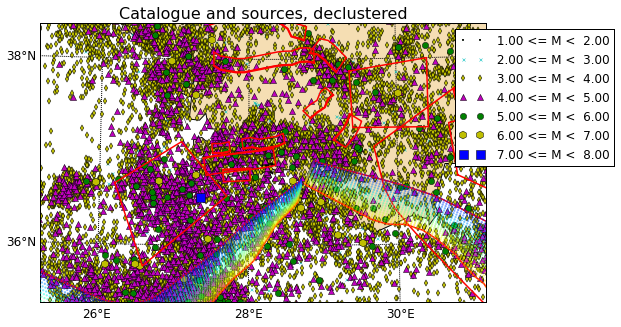

Number of events:  19049


In [15]:
my_map = HMTKBaseMap(map_config, 'Catalogue and sources, declustered')
my_map.add_catalogue(declustered, overlay=True)
my_map.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')
print 'Number of events: ', len(declustered.data['magnitude'])

In [50]:
selector = CatalogueSelector(declustered, create_copy=True)
source_ids = [source.id for source in source_model.sources]
print "Available source IDs:", source_ids

Available source IDs: ['TRCS394', 'TRCS391', 'TRCS331', 'TRCS271', 'TRCS322', 'TRCS393', 'TRCS390', 'TRCS268', 'TRCS913', 'TRCS330', 'HELL001', 'HELL002', 'CYPR001', 'CYPR002', 'AREA001']


In [84]:
fault_id = 'TRCS913'
r_km = 10
source = [source for source in source_model.sources if source.id == fault_id][0]
print "selecting events between %g and %g km depth" % (
    source.upper_depth, source.lower_depth)
print "selecting within Joyner-Boore distance %g km" % r_km
source.select_catalogue(selector, r_km,
                        distance_metric='joyner-boore', 
                        upper_eq_depth=source.upper_depth,
                        lower_eq_depth=source.lower_depth)
n_events = source.catalogue.get_number_events()
print "Found %d events" % n_events

selecting events between 0 and 40 km depth
selecting within Joyner-Boore distance 10 km
Found 636 events


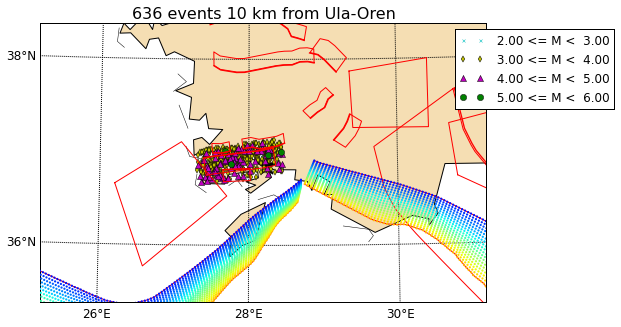

In [85]:
my_map = HMTKBaseMap(
    map_config, '%d events %d km from %s' % (n_events, r_km, source.name))
my_map.add_catalogue(source.catalogue, overlay=True)
my_map.add_source_model(source_model, area_border='r-', overlay=True)
my_map.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k')

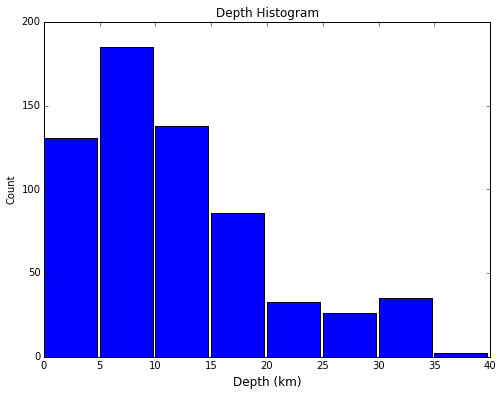

In [86]:
cp.plot_depth_histogram(source.catalogue, 5)

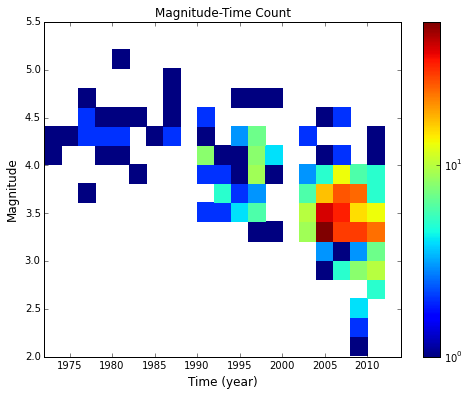

In [87]:
cp.plot_magnitude_time_density(source.catalogue, 0.2, 2)

Source TRCS913 completeness table using Stepp (1971)


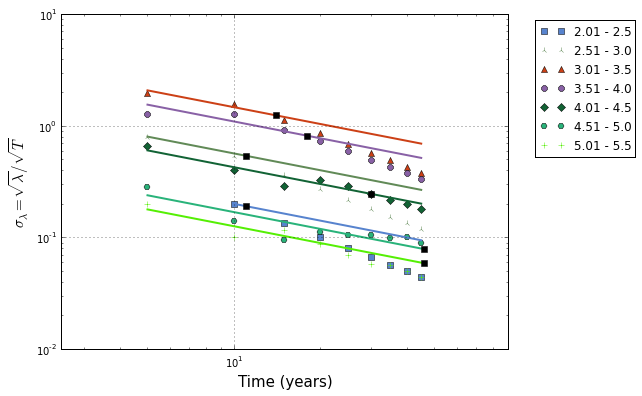

[[ 2004.      2. ]
 [ 2004.      2.5]
 [ 2001.      3. ]
 [ 1997.      3.5]
 [ 1985.      4. ]
 [ 1969.      4.5]
 [ 1969.      5. ]]


In [88]:
m_bin = 0.5
stepp_config = {'magnitude_bin': m_bin, 'time_bin': 5.0, 
               'increment_lock': True}
completeness_algorithm = Stepp1971()
completeness_table_stepp_source = completeness_algorithm.completeness(
    source.catalogue, stepp_config)
print 'Source %s completeness table using Stepp (1971)' % fault_id
plot_stepp_1972.create_stepp_plot(completeness_algorithm)
plt.show()

degradation = (completeness_table_stepp_source[:-1,0]
               < completeness_table_stepp_source[1:,0])
if np.any(degradation):
    print "ERROR: Completeness table shows increase in completeness magnitude between %d and %d" % (
        completeness_table_stepp_source[np.where(degradation)[0][0],0],
        completeness_table_stepp_source[np.where(degradation)[0][0] + 1,0])
    
print completeness_table_stepp_source

In [89]:
completeness_table_stepp_edited = np.array([
        [2007, 2.5],
        [2002, 3.0],
        [1992, 3.5], 
        [1970, 4.0],
        [1967, 5.0],
    ]) 

completeness_table_catalog_truncated = np.array([
        [2004, 3.5],
        [1994, 4.0], 
        [1974, 4.5],
    ]) 

completeness_table_brutal = np.array([
        [2004, 3.0],
    ]) 

completeness_table_source = completeness_table_catalog_truncated

In [90]:
print 'Source %s Gutenberg-Richter fitting' % fault_id

# Weichert Method
recurrence1 = occurrence.weichert.Weichert()
weichert_config = {'magnitude_interval': m_bin, 'bvalue': 1.0, 
                   'itstab': 1e-5, 'maxiter': 1000}
bval1, sigmab1, aval1, sigmaa1 = recurrence1.calculate(
    source.catalogue, weichert_config, completeness=completeness_table_source)

print "--- Weichert ---"
print "b = %.4f +/- %.4f, a = %.4f +/- %.4f" % (
    bval1, sigmab1, aval1, sigmaa1)

# Weighted Maximum Likelihood Method
recurrence2 = occurrence.b_maximum_likelihood.BMaxLikelihood()
wml_config = {'magnitude_interval': m_bin, 'Average Type': 'Weighted'}
bval2, sigmab2, aval2, sigmaa2 = recurrence2.calculate(
    source.catalogue, wml_config, completeness=completeness_table_source)

print "--- Weighted Maximum Likelihood ---"
print "b = %.4f +/- %.4f, a = %.4f +/- %.4f" % (
    bval2, sigmab2, aval2, sigmaa2)

Source TRCS913 Gutenberg-Richter fitting
--- Weichert ---
b = 1.5593 +/- 0.0590, a = 6.6002 +/- 0.0196
--- ctime 2004.0  m_c 3.5
--- ctime 1994.0  m_c 4.0
--- ctime 1974.0  m_c 4.5
--- Weighted Maximum Likelihood ---
b = 1.2828 +/- 0.0958, a = 5.7678 +/- 0.3424


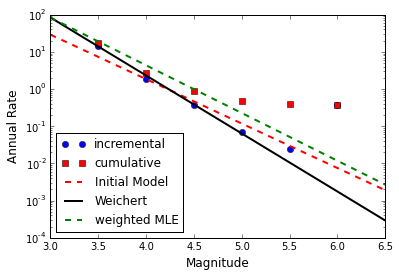

In [91]:
aValue=5.04488636044 
bValue=1.19488371932
end_year = np.max(source.catalogue.data['year'])
recurrence_source = cp.get_completeness_adjusted_table(
    source.catalogue, completeness_table_source, m_bin, end_year)
plt.semilogy(recurrence_source[:, 0], recurrence_source[:, 1], 'bo', label='incremental')
plt.semilogy(recurrence_source[:, 0], recurrence_source[:, 2], 'rs', label='cumulative')
x_lim = np.array([recurrence_source[0, 0] - m_bin, recurrence_source[-1, 0] + m_bin])
plt.xlim(x_lim)
plt.plot(x_lim, 10**(aValue - bValue*x_lim), 'r--', label='Initial Model')
plt.plot(x_lim, 10**(aval1 - bval1*x_lim), 'k-', label='Weichert')
plt.plot(x_lim, 10**(aval2 - bval2*x_lim), 'g--', label='weighted MLE')
plt.xlabel('Magnitude', fontsize='large')
plt.ylabel('Annual Rate', fontsize='large')
plt.legend(loc='lower left')
plt.show()

In [80]:
bins = np.matrix(source_model.sources[0].mfd.get_annual_occurrence_rates())[:,0]
rates = np.zeros((len(bins), len(source_model.sources)))
for i, source in enumerate(source_model.sources):
    rates[:,i] = np.array(source.mfd.get_annual_occurrence_rates())[:,1]

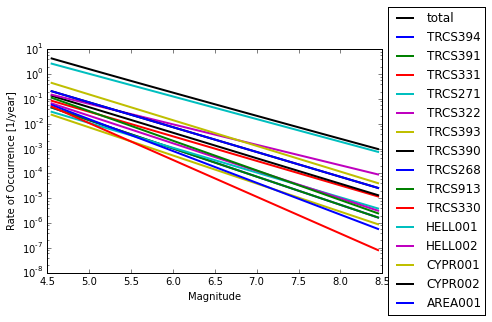

In [81]:
plt.semilogy(bins, rates.sum(1), 'k', label='total')
for rate, label in zip(rates.T, source_ids):
    plt.plot(bins, rate, label=label)
plt.xlabel("Magnitude")
plt.ylabel("Rate of Occurrence [1/year]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

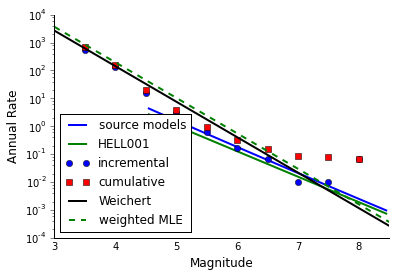

In [39]:
fault_id = 'HELL001'
source = [source for source in source_model.sources if source.id == fault_id][0]

plt.semilogy(bins, rates.sum(1), label='source models')
plt.semilogy(bins, np.array(source.mfd.get_annual_occurrence_rates())[:,1], label=fault_id)

plt.semilogy(recurrence_cat[:, 0], recurrence_cat[:, 1], 'bo', label='incremental')
plt.semilogy(recurrence_cat[:, 0], recurrence_cat[:, 2], 'rs', label='cumulative')
x_lim = np.array([recurrence_cat[0, 0] - m_bin, recurrence_cat[-1, 0] + m_bin])
plt.xlim(x_lim)
plt.plot(x_lim, 10**(a_cat_1 - b_cat_1*x_lim), 'k-', label='Weichert')
plt.plot(x_lim, 10**(a_cat_2 - b_cat_2*x_lim), 'g--', label='weighted MLE')
plt.xlabel('Magnitude', fontsize='large')
plt.ylabel('Annual Rate', fontsize='large')
tb.remove_chartjunk(plt.gca(),['top','right'])
plt.legend(loc='lower left')
plt.show()

In [27]:
print "--- Weichert ---"
print "a = %.4f +/- %.4f, b = %.4f +/- %.4f" % (
    b_cat_1, sigma_b_cat_1, a_cat_1, sigma_a_cat_1)


--- Weichert ---
a = 1.2720 +/- 0.0069, b = 7.2404 +/- 0.0030
